In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [313]:
datapath = 'data/'
train = pd.read_csv(datapath+'train.csv')
test = pd.read_csv(datapath+'test.csv')
# 66% Train, 33% test
data = train.append(test)
# data shape - 1309, 12
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


Variable	Definition	    Key

survival 	Survival 	    0 = No, 1 = Yes
pclass 	    Ticket class 	1 = 1st, 2 = 2nd, 3 = 3rd
sex 	    Sex 	
Age 	    Age in years 	
sibsp 	    # of siblings / spouses aboard the Titanic 	
parch 	    # of parents / children aboard the Titanic 	
ticket 	    Ticket number 	
fare 	    Passenger fare 	
cabin 	    Cabin number 	
embarked 	Port of Embarkation 	C = Cherbourg, Q = Queenstown, S = Southampton

In [314]:
# First fill missing values
print(data.count())
# Cabin has too much missing values, PassengerId is useless
print("Number of unique tickets {} for {} passengers".format(len(np.unique(data['Ticket'])), data.shape[0]))
# Tickets is too unique, no use for prediction

data.drop(['Cabin', 'PassengerId', 'Ticket'], axis=1, inplace=True)

Age            1046
Cabin           295
Embarked       1307
Fare           1308
Name           1309
Parch          1309
PassengerId    1309
Pclass         1309
Sex            1309
SibSp          1309
Survived        891
Ticket         1309
dtype: int64
Number of unique tickets 929 for 1309 passengers


In [315]:
# Age, Embarked and Fare have missing values

print(data[pd.isnull(data['Fare'])])
# Fill the Fare of the missing passenger with the median of the same Embarking point and Class
data.Fare.fillna(data.Fare[(data.Embarked == 'S') & (data['Pclass'] == 3)].median(), inplace=True);

# Fill Embarked and force 2.0 class to the most common
print(data.Embarked.value_counts())
data.replace({'Embarked' :{2.0 : 'S'}}, inplace=True)
data.Embarked.fillna('S', inplace=True)


      Age Embarked  Fare                Name  Parch  Pclass   Sex  SibSp  \
152  60.5        S   NaN  Storey, Mr. Thomas      0       3  male      0   

     Survived  
152       NaN  
S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [316]:
# Before we fill the age, extract the title to get the median age for each title 
# From 'Name' column extract 'Title' - Mr., Mrs., Master., Miss., other
data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
print(data['Title'].value_counts())   
cleanup_nums = {"Title":     {  'Rev' : 'Mr',
                                'Dr'  : 'Mr',
                                'Col' : 'Mr',
                                'Mlle': 'Miss',
                                'Major' : 'Mr',                            
                                'Ms'  :'Miss',                
                                'Mme' : 'Mrs',               
                                'Sir' : 'Mr'}}  # Replace most titles           
data.replace(cleanup_nums, inplace=True)
cleanup_nums = {"Title": {'Miss'  : 1,
                          'Mrs'   : 2,
                          'Master': 3,
                          'Mr'    : 4,
                          'Capt'  : 0,            
                          'Dona'  : 0,           
                          'Don'   : 0,           
                          'the Countess' : 0,
                          'Jonkheer' : 0,
                          'Lady' : 0}}
data.replace(cleanup_nums, inplace=True)

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Mme               1
Dona              1
Jonkheer          1
the Countess      1
Don               1
Sir               1
Lady              1
Capt              1
Name: Title, dtype: int64


In [317]:
# Fill the ages with the median for a title
median_ages = np.zeros((5))
for i in range(0, 5):
        median_ages[i] = data[(data.Title == i)]['Age'].dropna().median()
data['AgeFill'] = data.Age
for i in range(0, 5):
        data.loc[(data.Age.isnull()) & (data.Title == i) , 'AgeFill'] = median_ages[i]
data.drop(['Age'], axis = 1, inplace = True)

data.rename(index=str, columns={'AgeFill' : 'Age'}, inplace=True)

# Now there are no missing values in the dataset (Except the Survived on the test sample)
data.head()

,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Title,Age
0,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,4,22.0
1,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,2,38.0
2,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,1,26.0
3,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,2,35.0
4,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,4,35.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A10593390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0C91C400>]], dtype=object)

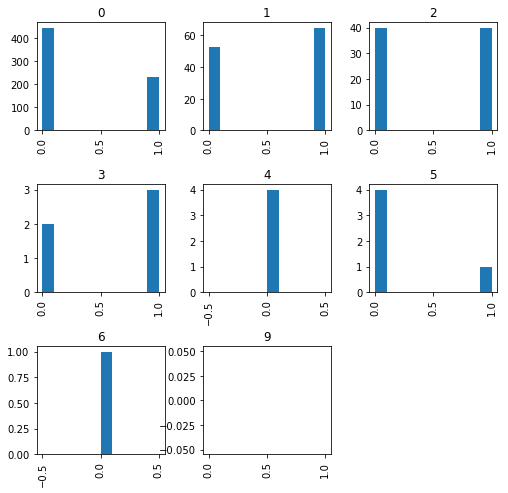

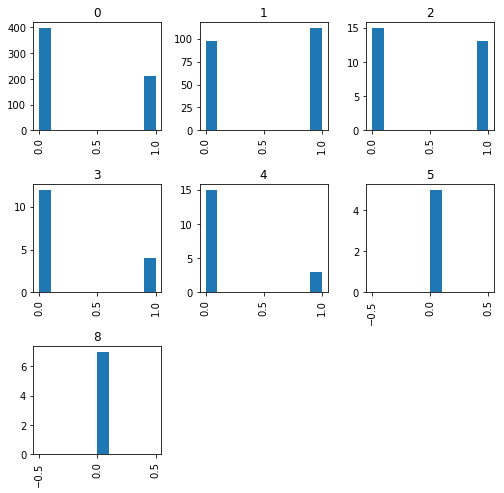

In [318]:
# Let's examine the Parch and SibSp

data['Survived'].hist(by=data['Parch'], figsize=(8,8))
data['Survived'].hist(by=data['SibSp'], figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0E5336D8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0C0CDF98>]], dtype=object)

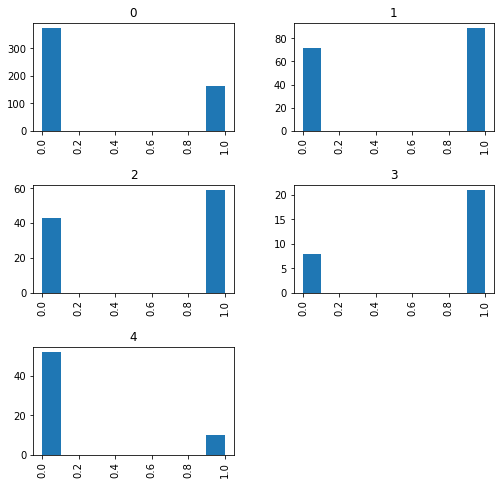

In [319]:
# Looks like loners and big families have less chance to survive
# Also the 2 variables seem to exibit similar pattern, so we can combine it into FamilySize

# 'Parch' and 'SibSp' have a similar pattern, so combine them in one
data['FamilySize'] = data['Parch'] + data['SibSp']
# Threshold the family size to 4+
data.loc[data.FamilySize > 4, 'FamilySize'] = 4
data['Survived'].hist(by=data['FamilySize'], figsize=(8,8))

In [320]:
# FamilySize now looks better than the Parch and SibSp, so we can use that instead
# We can still extract the family name from name to see if families sink together but it is too complicated for now
data.drop(['Parch', 'SibSp', 'Name'], axis = 1, inplace = True)

data.head()

,Embarked,Fare,Pclass,Sex,Survived,Title,Age,FamilySize
0,S,7.2500,3,male,0.0,4,22.0,1
1,C,71.2833,1,female,1.0,2,38.0,1
2,S,7.9250,3,female,1.0,1,26.0,0
3,S,53.1000,1,female,1.0,2,35.0,1
4,S,8.0500,3,male,0.0,4,35.0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0F2F1898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0B896550>]], dtype=object)

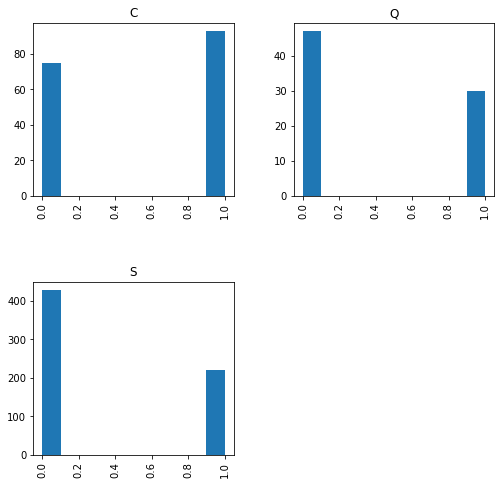

In [321]:
data['Survived'].hist(by=data['Embarked'], figsize=(8,8))
# Embarked looks like it is explaining some variability, so keep it for now

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0F39F780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0F57C8D0>]], dtype=object)

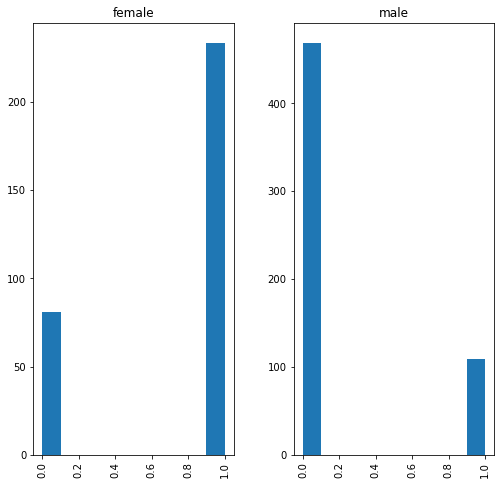

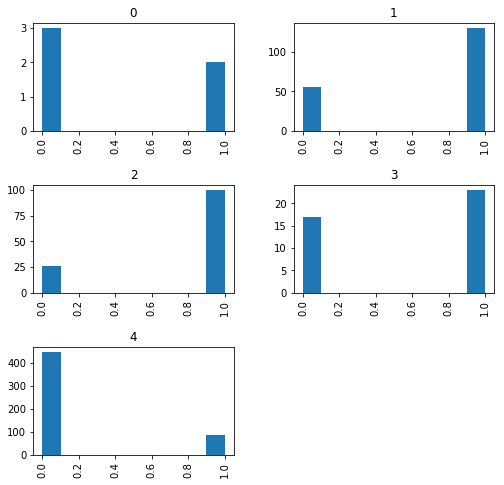

In [293]:
data['Survived'].hist(by=data['Sex'], figsize=(8,8))
data['Survived'].hist(by=data['Title'], figsize=(8,8))
# Also good predictors

In [322]:
# Code 'Embarked' and 'Sex' as numbers
cleanup_nums = {"Embarked":     {"C": 0, "Q": 1, "S": 2},
                "Sex":          {"male": 0, "female": 1}}
data.replace(cleanup_nums, inplace=True)
data.head()

,Embarked,Fare,Pclass,Sex,Survived,Title,Age,FamilySize
0,2,7.2500,3,0,0.0,4,22.0,1
1,0,71.2833,1,1,1.0,2,38.0,1
2,2,7.9250,3,1,1.0,1,26.0,0
3,2,53.1000,1,1,1.0,2,35.0,1
4,2,8.0500,3,0,0.0,4,35.0,0


In [323]:
# Bin Fare and Age for plotting against Survived
data[['Fare','Age']].describe()
print(data[data['Fare'] > 250].shape)
# There are only few examples with Fare more than 250, so if thresholding that won't lose much info
print(data[data['Age'] > 65].shape)
# Same for people aged 65+

data.loc[data.Fare > 250, 'Fare'] = 250
data.loc[data.Age > 65, 'Age'] = 65

n_bins = 8
for i in range(n_bins):
    bin_width = 250 / n_bins
    data.loc[(data.Fare > bin_width * i) & (data.Fare < bin_width * (i + 1)), 'Fare'] = i
    bin_width = 65 / n_bins
    data.loc[(data.Age > bin_width * i) & (data.Age < bin_width * (i + 1)), 'Age'] = i


(17, 8)
(10, 8)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021A0E46A8D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000021A11148EB8>]], dtype=object)

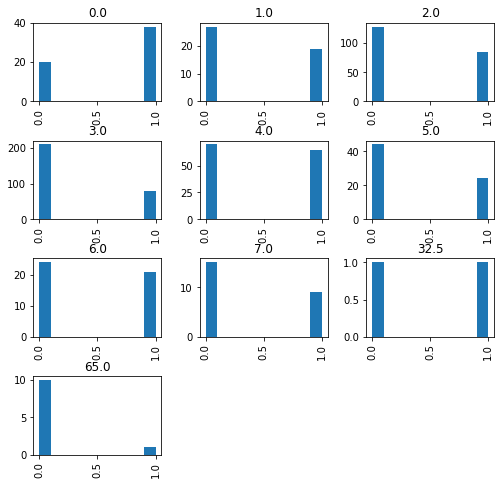

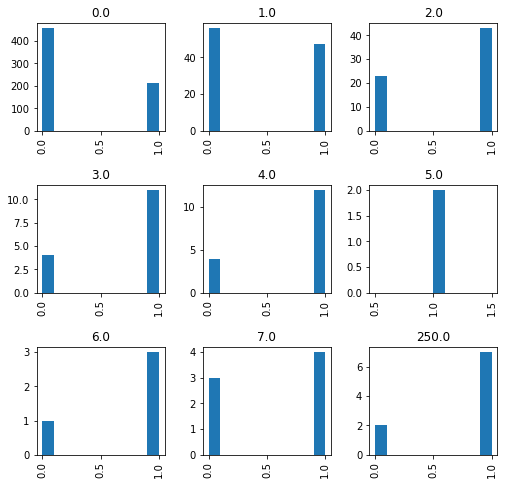

In [325]:
data['Survived'].hist(by=data['Age'], figsize=(8,8))
data['Survived'].hist(by=data['Fare'], figsize=(8,8))
# Good predictors

In [329]:
data.head()
# Cleaned data is ready

,Embarked,Fare,Pclass,Sex,Survived,Title,Age,FamilySize
0,2,0.0,3,0,0.0,4,2.0,1
1,0,2.0,1,1,1.0,2,4.0,1
2,2,0.0,3,1,1.0,1,3.0,0
3,2,1.0,1,1,1.0,2,4.0,1
4,2,0.0,3,0,0.0,4,4.0,0


In [334]:
# Split the data to features, labels, train and test
collist = data.columns.tolist()
collist.remove('Survived')

y = data['Survived'].as_matrix()
x = data[collist].as_matrix()

# Force everything to int8 - efficient for computation and memory
x_train = x[:train.shape[0]].astype('int8')
y_train = y[:train.shape[0]].astype('int8')
x_test = x[train.shape[0]:].astype('int8')


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(891, 7)
(891,)
(418, 7)


In [337]:
# SAVE THE CLEANED DATA ON h5py tables

array([[2, 0, 3, ..., 4, 2, 1],
       [0, 2, 1, ..., 2, 4, 1],
       [2, 0, 3, ..., 1, 3, 0],
       ..., 
       [2, 0, 3, ..., 1, 2, 3],
       [0, 0, 1, ..., 4, 3, 0],
       [1, 0, 3, ..., 4, 3, 0]], dtype=int8)

In [ ]:
# Now lets get to analysis
